# Building Autoencoders in Keras

I followed [this Autoencoder tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) with actual code and visualization for
autoencoder based reconstruction and noise removal.

### Overview

"Autoencoding" is a data compression algorithm where the compression and decompression functions are 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human. The compression and decompression functions are almost always implemented with neural networks.

To build an autoencoder, you need three things:  
1. encoding function
2. decoding function
3. a distance function between the amount of information loss between the compressed representation of your data and the decompressed representation (i.e. a "loss" function)

Although autoencoders are rarely used in practical applications, they have attracted research and attention because they have long been thought to be a potential avenue for solving the problem of unsupervised learning.

### Simple Autoencoder based on a fully-connected layer

In [1]:
import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

In [2]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

Now that we have created a separate encoder model as well as the decoder model, we can train our autoencoder to reconstruct MNIST digits.

In [3]:
# 1. Configure our model to use a per-pixel binary crossentropy loss, and the Adam optimizer:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# 2. Prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

# 3. Normalize all values between 0 and 1 and flatten the 28x28 images into vectors of size 784.
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 784)
(10000, 784)


In [4]:
# Train autoencoder for 50 epochs
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

# reaches a stable train/validation loss value of about 0.09

Epoch 1/50
235/235 [==============================] - 3s 12ms/step - loss: 0.3806 - val_loss: 0.1904
Epoch 2/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1809 - val_loss: 0.1545
Epoch 3/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1500 - val_loss: 0.1335
Epoch 4/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1313 - val_loss: 0.1206
Epoch 5/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1201 - val_loss: 0.1126
Epoch 6/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1123 - val_loss: 0.1070
Epoch 7/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1071 - val_loss: 0.1028
Epoch 8/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1033 - val_loss: 0.0997
Epoch 9/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1005 - val_loss: 0.0974
Epoch 10/50
235/235 [==============================] - 2s 10ms/step - loss: 0.0983 - val_lo

Visualize the reconstructed inputs and the encoded representations using Matplotlib.

In [5]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

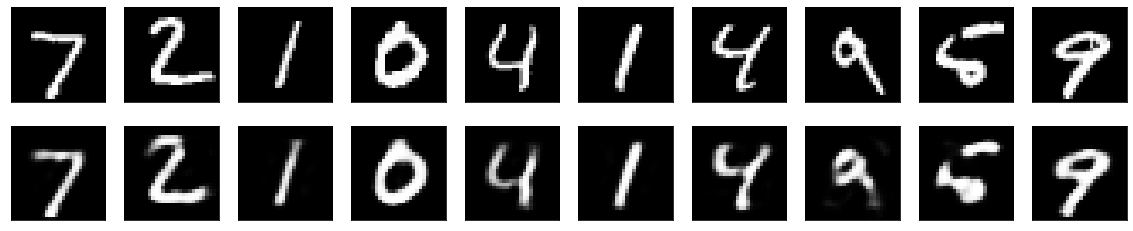

In [6]:
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

The top row is the original digits, and the bottom row is the reconstructed digits. We are losing quite a bit of detail with this basic approach.

### Sparse autoencoder

In the previous example, the representations were only constrained by the size of the hidden layer (32). However, another way to constrain the representations to be compact is to **add a sparsity contraint on the encoded representations**, so fewer units would "fire" at a given time. In Keras, this can be done by adding an activity_regularizer to our Dense layer.

In [7]:
from keras import regularizers

encoding_dim = 32

input_img = keras.Input(shape=(784,))
# Add a Dense layer with a L1 activity regularizer
encoded = layers.Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [8]:
# Train autoencoder for 100 epochs
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
235/235 [==============================] - 3s 11ms/step - loss: 0.3949 - val_loss: 0.2013
Epoch 2/100
235/235 [==============================] - 2s 10ms/step - loss: 0.1901 - val_loss: 0.1622
Epoch 3/100
235/235 [==============================] - 2s 10ms/step - loss: 0.1584 - val_loss: 0.1431
Epoch 4/100
235/235 [==============================] - 2s 10ms/step - loss: 0.1413 - val_loss: 0.1313
Epoch 5/100
235/235 [==============================] - 2s 10ms/step - loss: 0.1305 - val_loss: 0.1233
Epoch 6/100
235/235 [==============================] - 2s 10ms/step - loss: 0.1231 - val_loss: 0.1177
Epoch 7/100
235/235 [==============================] - 2s 10ms/step - loss: 0.1177 - val_loss: 0.1137
Epoch 8/100
235/235 [==============================] - 2s 10ms/step - loss: 0.1144 - val_loss: 0.1108
Epoch 9/100
235/235 [==============================] - 2s 10ms/step - loss: 0.1113 - val_loss: 0.1087
Epoch 10/100
235/235 [==============================] - 2s 10ms/step - loss: 0.109

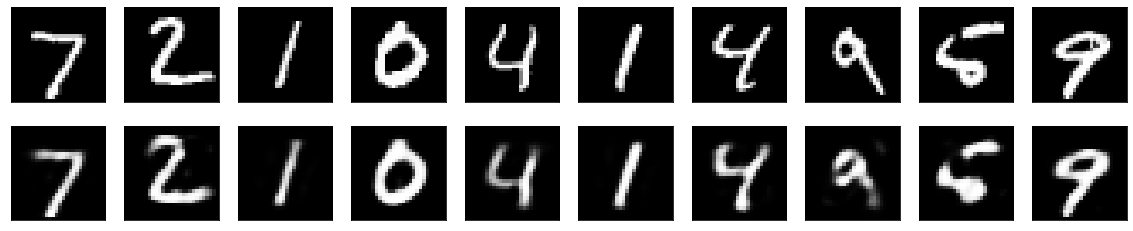

In [9]:
decoded_imgs = autoencoder.predict(x_test)

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Deep fully-connected autoencoder

We do not have to limit ourselves to a single layer as encoder or decoder, so we could instead use a stack of layers:

In [10]:
input_img = keras.Input(shape=(784,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

In [11]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
235/235 [==============================] - 4s 17ms/step - loss: 0.3347 - val_loss: 0.1639
Epoch 2/100
235/235 [==============================] - 4s 16ms/step - loss: 0.1565 - val_loss: 0.1354
Epoch 3/100
235/235 [==============================] - 4s 16ms/step - loss: 0.1329 - val_loss: 0.1232
Epoch 4/100
235/235 [==============================] - 4s 16ms/step - loss: 0.1225 - val_loss: 0.1161
Epoch 5/100
235/235 [==============================] - 4s 16ms/step - loss: 0.1159 - val_loss: 0.1105
Epoch 6/100
235/235 [==============================] - 4s 16ms/step - loss: 0.1113 - val_loss: 0.1071
Epoch 7/100
235/235 [==============================] - 4s 16ms/step - loss: 0.1077 - val_loss: 0.1046
Epoch 8/100
235/235 [==============================] - 4s 16ms/step - loss: 0.1054 - val_loss: 0.1023
Epoch 9/100
235/235 [==============================] - 4s 16ms/step - loss: 0.1033 - val_loss: 0.1005
Epoch 10/100
235/235 [==============================] - 4s 16ms/step - loss: 0.101

After 100 epochs, it reaches a train & validation loss of ~0.08, a bit better than previous models. Our reconstructed digits also look a bit better.

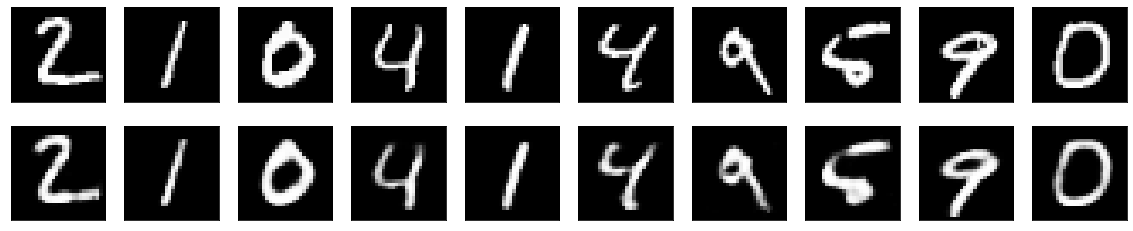

In [12]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Deep convolutional autoencoder

Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders because they perform much better.

In this example, the encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [13]:
import keras
from keras import layers

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

To train it, we use the original MNIST digits with shape (samples, 3, 28, 28) and normalize pixel values between 0 and 1.

In [14]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [15]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
469/469 [==============================] - 75s 158ms/step - loss: 0.3207 - val_loss: 0.1489
Epoch 2/50
469/469 [==============================] - 74s 158ms/step - loss: 0.1444 - val_loss: 0.1293
Epoch 3/50
469/469 [==============================] - 74s 157ms/step - loss: 0.1278 - val_loss: 0.1201
Epoch 4/50
469/469 [==============================] - 73s 157ms/step - loss: 0.1198 - val_loss: 0.1154
Epoch 5/50
469/469 [==============================] - 74s 157ms/step - loss: 0.1160 - val_loss: 0.1117
Epoch 6/50
469/469 [==============================] - 73s 157ms/step - loss: 0.1127 - val_loss: 0.1095
Epoch 7/50
469/469 [==============================] - 73s 156ms/step - loss: 0.1103 - val_loss: 0.1079
Epoch 8/50
469/469 [==============================] - 74s 157ms/step - loss: 0.1087 - val_loss: 0.1060
Epoch 9/50
469/469 [==============================] - 74s 157ms/step - loss: 0.1068 - val_loss: 0.1049
Epoch 10/50
469/469 [==============================] - 74s 157ms/step - l

The model converges to a loss of 0.093, significantly better than our previous models; this is in large part due to the higher entropic capacity of the encoded representation, 128 dimensions vs. 32 previously. Let's take a look at the reconstructed images:

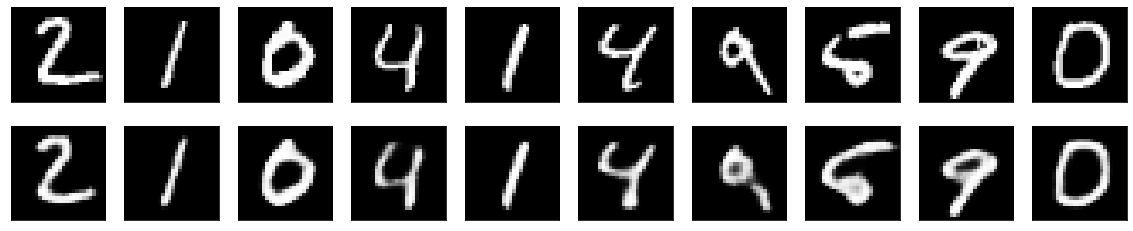

In [16]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We can also have a look at the 128-dimensional encoded representations. These representations are 8x4x4, so we reshape them to 4x32 in order to be able to display them as grayscale images.

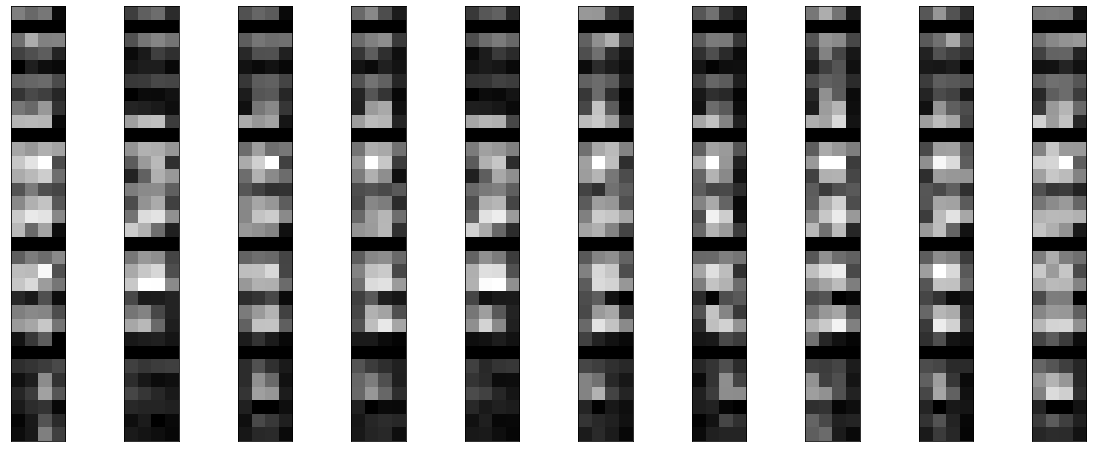

In [17]:
encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 8))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape((4, 4 * 8)).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Image denoising model

To put our convolutional autoencoder to work on an image denoising problem, we will train the autoencoder to map noisy digits images to clean digits images. 

We will generate synthetic noisy digits by applying a gaussian noise matrix and clipping the images between 0 and 1.

In [18]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

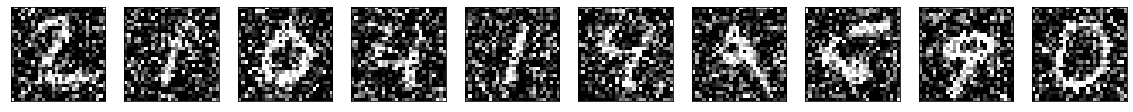

In [19]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Compared to the previous convolutional autoencoder, in order to improve the quality of the reconstructed, we'll use a slightly different model with more filters per layer:

In [20]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [22]:
# Train it for 100 epochs
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/100
469/469 [==============================] - 143s 305ms/step - loss: 0.2568 - val_loss: 0.1188
Epoch 2/100
469/469 [==============================] - 143s 304ms/step - loss: 0.1166 - val_loss: 0.1090
Epoch 3/100
469/469 [==============================] - 143s 305ms/step - loss: 0.1090 - val_loss: 0.1048
Epoch 4/100
469/469 [==============================] - 143s 305ms/step - loss: 0.1050 - val_loss: 0.1025
Epoch 5/100
469/469 [==============================] - 142s 304ms/step - loss: 0.1029 - val_loss: 0.1015
Epoch 6/100
469/469 [==============================] - 142s 304ms/step - loss: 0.1017 - val_loss: 0.1001
Epoch 7/100
469/469 [==============================] - 142s 303ms/step - loss: 0.1007 - val_loss: 0.0992
Epoch 8/100
469/469 [==============================] - 143s 304ms/step - loss: 0.0998 - val_loss: 0.0986
Epoch 9/100
469/469 [==============================] - 143s 304ms/step - loss: 0.0992 - val_loss: 0.0979
Epoch 10/100
469/469 [==============================] -

Now let's take a look at the results. Top, the noisy digits fed to the network, and bottom, the digits are reconstructed by the network.

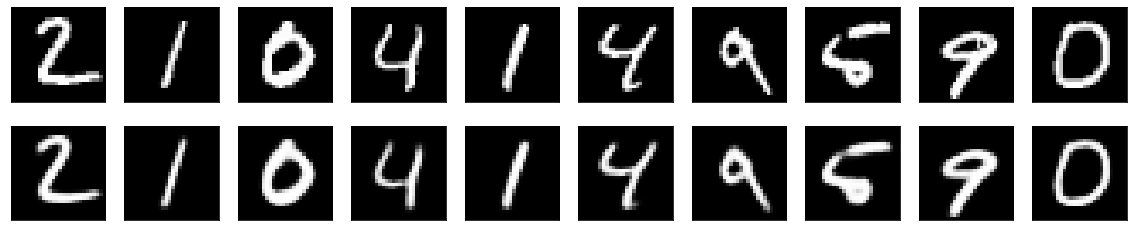

In [23]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Sequence-to-sequence autoencoder

If the inputs are sequences, rather than vectors or 2D images, then it may be good to use as encoder and decoder a type of model that can capture temporal structure, such as a LSTM. 

To build a LSTM-based autoencoder, first use a LSTM encoder to turn your input sequences into a single vector that contains information about the entire sequence, then repeat this vector n times (where n is the number of timesteps in the output sequence), and run a LSTM decoder to turn this constant sequence into the target sequence.

### Variational Autoencoder (VAE)

A Variational autoencoder is a type of autoencoder with added constraints on the encoded representations being learned, so it learns a latent variable model for its input data. Instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. If you sample points from this distribution, you can generate new input data samples.

In [24]:
# Here's our encoder network, mapping inputs to our latent distribution parameters:

original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [25]:
# Use these parameters to sample new similar points from the latent space:

from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [26]:
# Map these sampled latent points back to reconstructed inputs:

# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')


The parameters of the model are trained via two loss functions: a reconstruction loss forcing the decoded samples to match the initial inputs, and the KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term.

In [27]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [28]:
# Train our VAE on MNIST digits:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/100
1875/1875 [==============================] - 7s 4ms/step - loss: 222.8215 - val_loss: 170.9002
Epoch 2/100
1875/1875 [==============================] - 7s 4ms/step - loss: 168.9810 - val_loss: 164.5540
Epoch 3/100
1875/1875 [==============================] - 7s 4ms/step - loss: 163.8276 - val_loss: 161.6366
Epoch 4/100
1875/1875 [==============================] - 7s 4ms/step - loss: 160.9715 - val_loss: 159.9164
Epoch 5/100
1875/1875 [==============================] - 7s 3ms/step - loss: 158.9167 - val_loss: 158.1983
Epoch 6/100
1875/1875 [==============================] - 6s 3ms/step - loss: 157.0350 - val_loss: 156.4509
Epoch 7/100
1875/1875 [==============================] - 6s 3ms/step - loss: 155.5470 - val_loss: 155.0739
Epoch 8/100
1875/1875 [==============================] - 6s 3ms/step - loss: 154.4519 - val_loss: 154.1861
Epoch 9/100
1875/1875 [==============================] - 6s 3ms/step - loss: 153.2984 - val_loss: 153.2196
Epoch 10/100
1875/1875 [=============

Because the VAE is a generative model, we can also use it to generate new digits. Here we will scan the latent plane, sampling latent points at regular intervals, and generating the corresponding digit for each of these points. This gives us a visualization of the latent manifold that "generates" the MNIST digits.

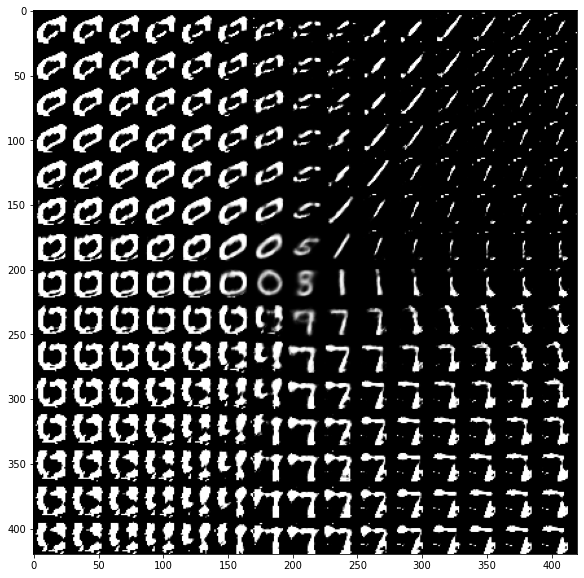

In [32]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()